In [1]:
using CSV, DataFrames, CairoMakie, wgregseq, Statistics, ColorSchemes, PlotUtils

#wgregseq.viz.default_makie!()

Precompiling wgregseq
        Info Given wgregseq was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? wgregseq
[ Info: Precompiling wgregseq [f8cc1c76-3494-412e-9b4b-01264b94fd02]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing wgregseq [f8cc1c76-3494-412e-9b4b-01264b94fd02].


In [2]:
font_by_path = "/Users/tomroeschinger/Library/Fonts/Lato-Regular.ttf"

"/Users/tomroeschinger/Library/Fonts/Lato-Regular.ttf"

In [53]:
theme = Theme(
    Axis = (
        backgroundcolor = "#f7f7fa",

        # Font sizes
        titlesize=12,
        xlabelsize=10,
        ylabelsize=10,
        xticklabelsize=8,
        yticklabelsize=8,

        # Font styles
        titlefont=font_by_path,
        xticklabelfont=font_by_path,
        yticklabelfont=font_by_path,
        xlabelfont=font_by_path,
        ylabelfont=font_by_path,

        # Grid
        xgridwidth=1.25,
        ygridwidth=1.25,
        xgridcolor="white",
        ygridcolor="white",
        xminorgridcolor="white",
        yminorgridcolor="white",
        xminorgridvisible=true,
        xminorgridwidth=1.,
        yminorgridvisible=true,
        yminorgridwidth=1,
        xgridstyle=:dash, 
        xminorgridstyle=:dash, 
        ygridstyle=:dash, 
        yminorgridstyle=:dash,

        # Box
        rightspinevisible=false,
        topspinevisible=false,
        leftspinevisible=false,
        bottomspinevisible=false

    ),

)
update_theme!(theme)

In [4]:
growth_conditions = CSV.read("../analysis/all_data/growth_conditions.csv", DataFrame, delim=';');

In [150]:
df_BS = CSV.read("../analysis/all_data/hypothetical_BS.csv", DataFrame);

## MAKE THIS COLORBLIND FRIENDLY

In [6]:
cmap = PlotUtils.cgrad(["#63ACBE", "#f7f7f7", "#EF875F"], [0, 0.4, 0.6, 1], alpha=0.7)

In [7]:
cmap2 = PlotUtils.cgrad(["#63ACBE", "#e6e6e6", "#EF875F"], [0, 0.25, 0.75, 1], alpha=1)

In [8]:
function plot_footprint(promoter, gc, rep, rev=false, d=2;save=true)

    df = CSV.read("../analysis/all_data/footprints/$gc-$(rep)_footprints.csv", DataFrame)
    y = df[(df.promoter .== promoter) .& (df.d .== d), :mut_info];
    
    df_ex = CSV.read("../analysis/all_data/expression_shifts/$gc-$(rep)_exshifts.csv", DataFrame)
    y_ex = df_ex[(df_ex.promoter .== promoter), :];
    
    
    fig = Figure(size=(600, 200))
    
    ax = Axis(fig[1 ,1], xlabel="Position relative to TSS", ylabel="Mutual Information [bits]", xticks=(collect(-110:10:40)), title="$promoter in $(growth_conditions[gc, :Condition])")
    
    _df = df_BS[(df_BS.gc .== gc) .& (df_BS.promoter .== promoter), :]
    
    for bs_df in groupby(_df, :binding_site)
        _x = convert(Vector{Int64}, sort(bs_df.pos)) .- 0.5
    
        ex_shift = y_ex[map(x -> x ∈ bs_df.pos, y_ex.pos), :]
        color = cmap[(mean(ex_shift.expression_shift) + 1) / 2]
        
        push!(_x, _x[end] + 1)
        if rev
            _x = (_x .* -1) .- 71
        end
        band!(
            ax, 
            _x, 
            fill(0, length(bs_df.pos) + 1), 
            fill(maximum(y),length(bs_df.pos) + 1), 
            color=color, 
            )
    end
    if rev
        barplot!(ax, 44-d:-1:-115+d, y, gap=0)
        ax.xticks = (collect(-110:10:40), string.(collect(40:-10:-110)))
    else
        barplot!(ax, -115+d:44-d, y, gap=0)
    end
    if save
        save("annotated_footprints/$promoter-$gc-$rep.pdf", fig)
    end
    return ax, fig
end

plot_footprint (generic function with 3 methods)

In [9]:
function plot_footprint_colored(promoter, gc, rep, rev=false, d=2;save_fig=true)

    df = CSV.read("../analysis/all_data/footprints/$gc-$(rep)_footprints.csv", DataFrame)
    y = df[(df.promoter .== promoter) .& (df.d .== d), :mut_info];
    
    df_ex = CSV.read("../analysis/all_data/expression_shifts/$gc-$(rep)_exshifts.csv", DataFrame)
    y_ex = df_ex[(df_ex.promoter .== promoter), :];
    
    fig = Figure(size=(600, 200))
    
    ax = Axis(fig[1 ,1], xlabel="Position relative to TSS", ylabel="Mutual Information [bits]", xticks=(collect(-110:10:40)), title="$promoter in $(growth_conditions[gc, :Condition])")
    
    _df = df_BS[(df_BS.gc .== gc) .& (df_BS.promoter .== promoter), :]
    ex_means = combine(groupby(y_ex, :pos), :expression_shift => mean => :ex_mean)
    ma, mi = maximum(ex_means.ex_mean), minimum(ex_means.ex_mean)
    
    flatten_ex_shift = [(t - mi) / (ma - mi) for t in ex_means.ex_mean]
    c_zero =  - mi / (ma - mi)
    
    cmap2 = PlotUtils.cgrad(["#63ACBE", "#e6e6e6", "#EF875F"], [0, c_zero/2, (c_zero + 1)/2, 1], alpha=1)
    color = [cmap2[t] for t in flatten_ex_shift]
    for bs_df in groupby(_df, :binding_site)
        _x = convert(Vector{Int64}, sort(bs_df.pos)) .- 0.5
        push!(_x, _x[end] + 1)
        if rev
            _x = (_x .* -1) .- 71
        end
        #=band!(
            ax, 
            _x, 
            fill(0, length(bs_df.pos) + 1), 
            fill(maximum(y),length(bs_df.pos) + 1) .* 1.1,
            color=("gray", 0.3)
            )=#
        lines!(
            ax,
            _x,
            fill(maximum(y),length(bs_df.pos) + 1) .* 1.1,
            color="black",
            linewidth=2
            )
    end
    if rev
        barplot!(ax, 44-d:-1:-115+d, y, gap=0, color=color[1+d:end-d])
        ax.xticks = (collect(-110:10:40), string.(collect(40:-10:-110)))
    else
        barplot!(ax, -115+d:44-d, y, gap=0, color=color[1+d:end-d])
    end
    if save_fig
        save("annotated_footprints/$promoter-$gc-$rep.pdf", fig)
    end
    return ax, fig
end

plot_footprint_colored (generic function with 3 methods)

# Gold Standards

## araBp

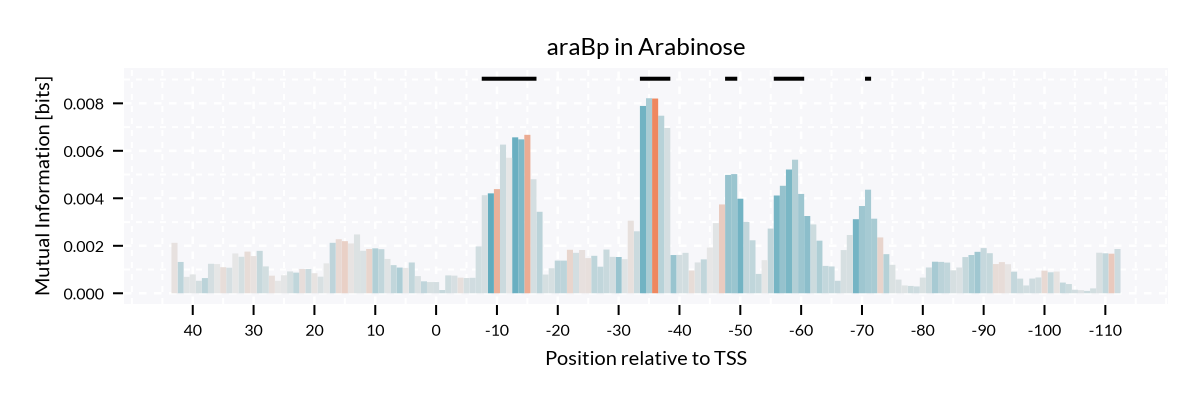

In [54]:
promoter = "araBp"
gc = 3
rep = 1

_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

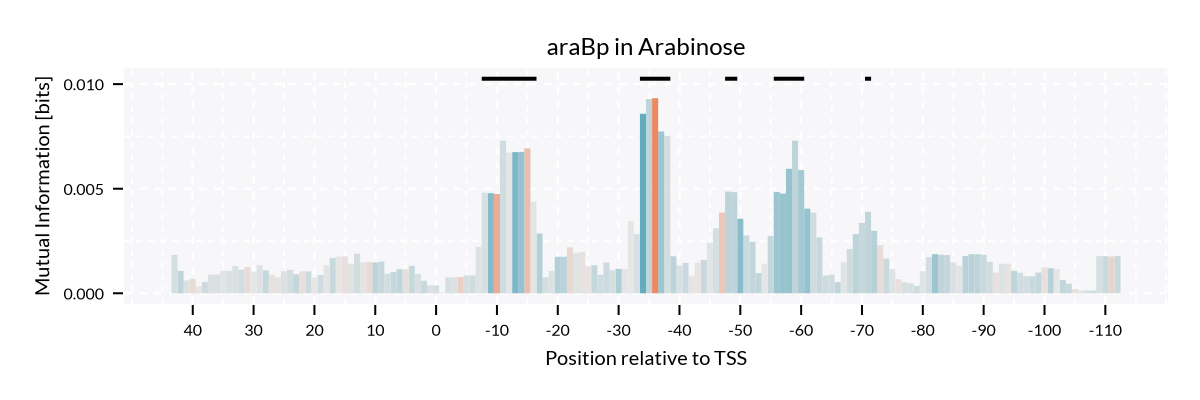

In [55]:
promoter = "araBp"
gc = 3
rep = 2

_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

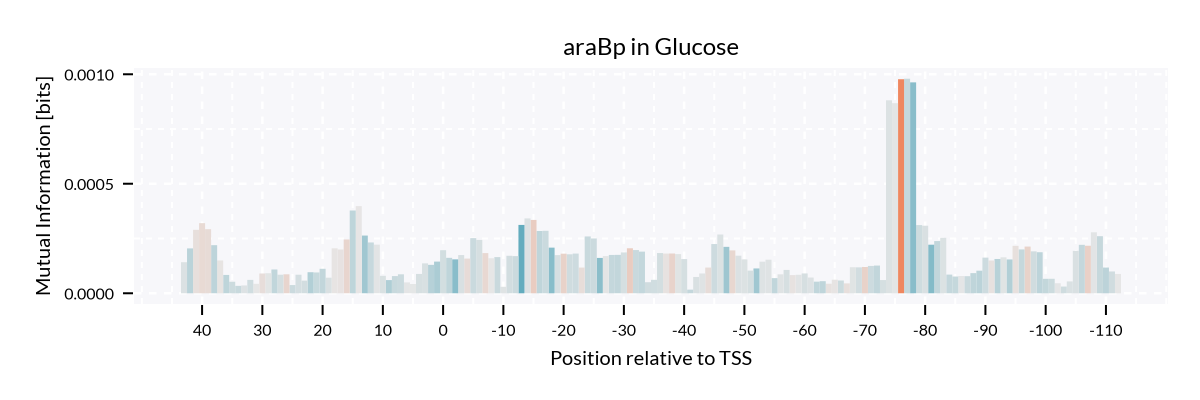

In [56]:
promoter = "araBp"
gc = 1
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

## znuC

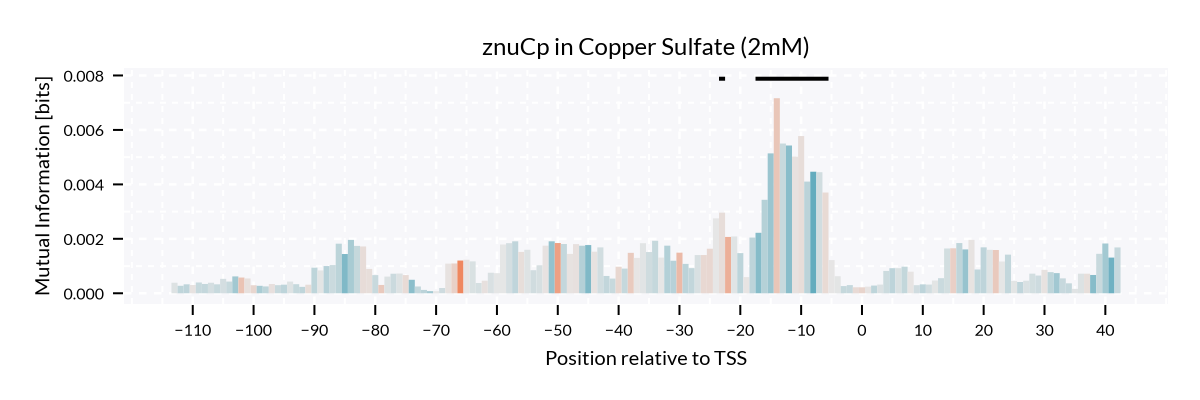

In [156]:
promoter = "znuCp"
gc = 38
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

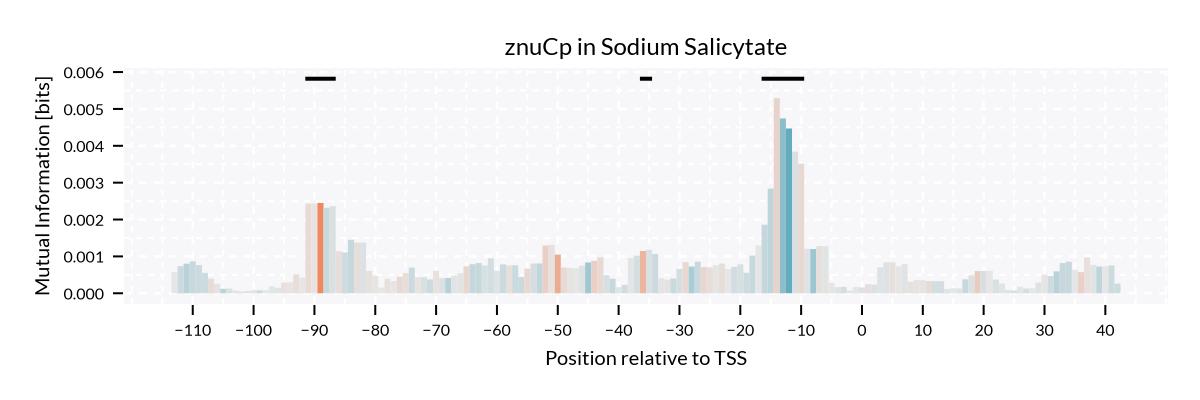

In [157]:
promoter = "znuCp"
gc = 5
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

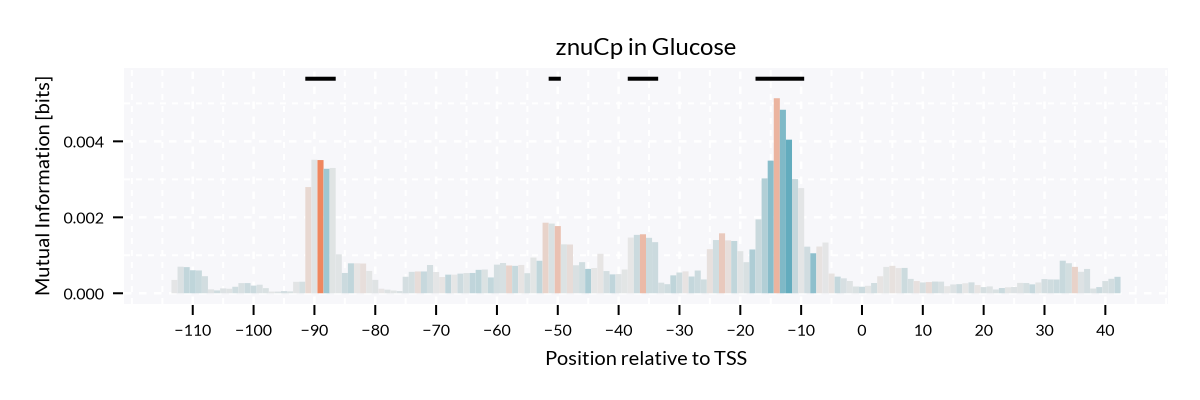

In [123]:
promoter = "znuCp"
gc = 1
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

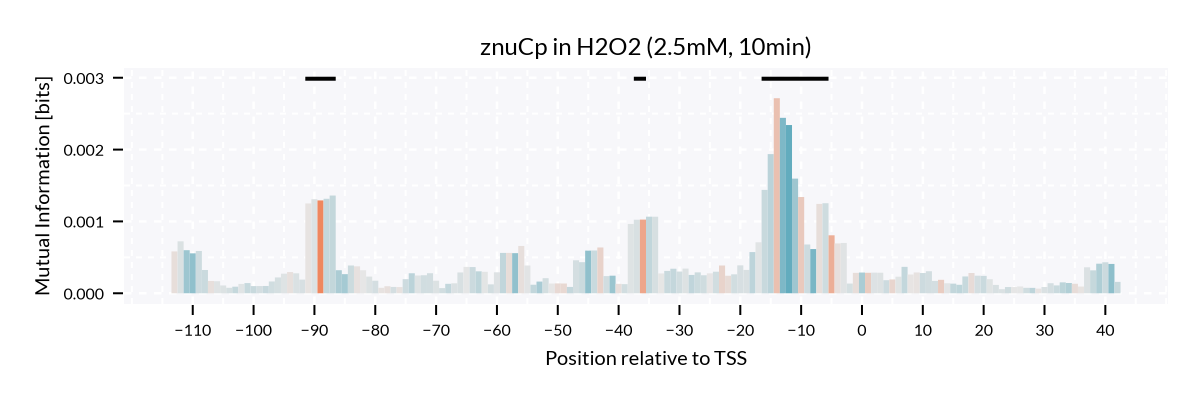

In [124]:
promoter = "znuCp"
gc = 28
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

## ftsK

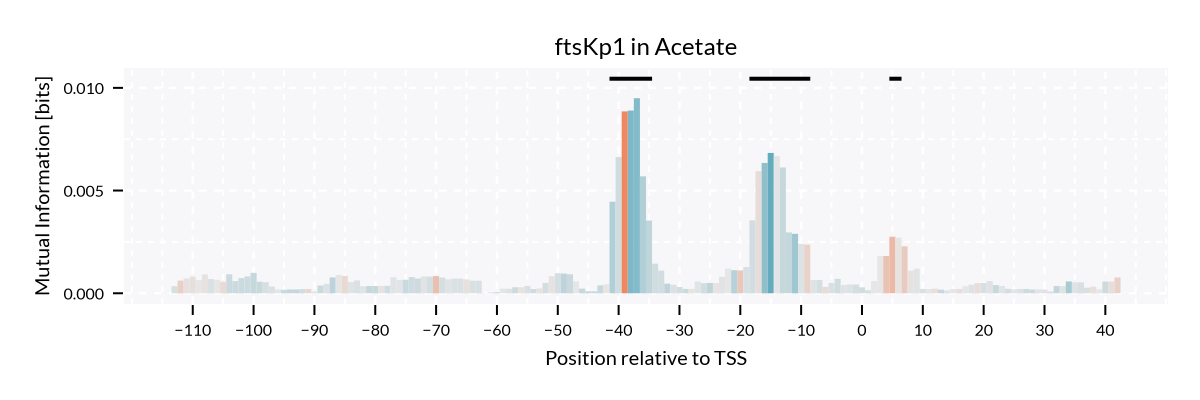

In [158]:
promoter = "ftsKp1"
gc = 39
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

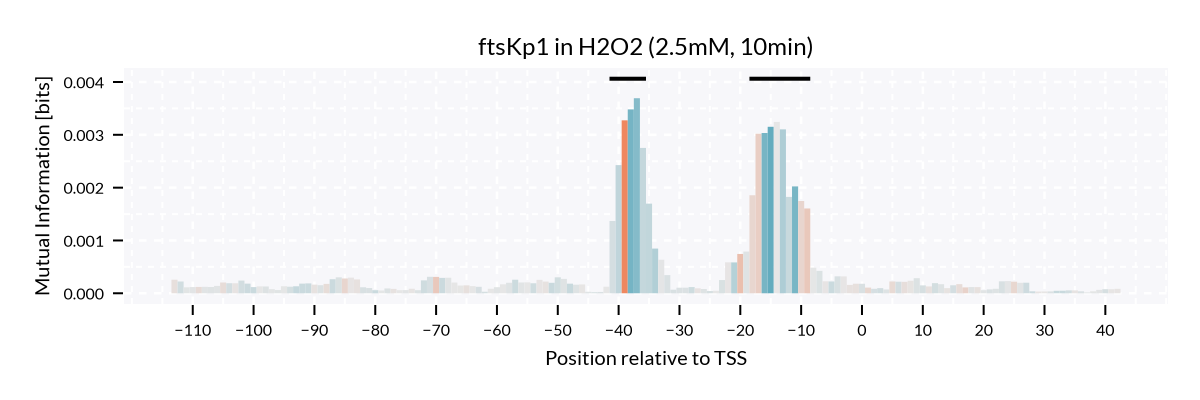

In [119]:
promoter = "ftsKp1"
gc = 28
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

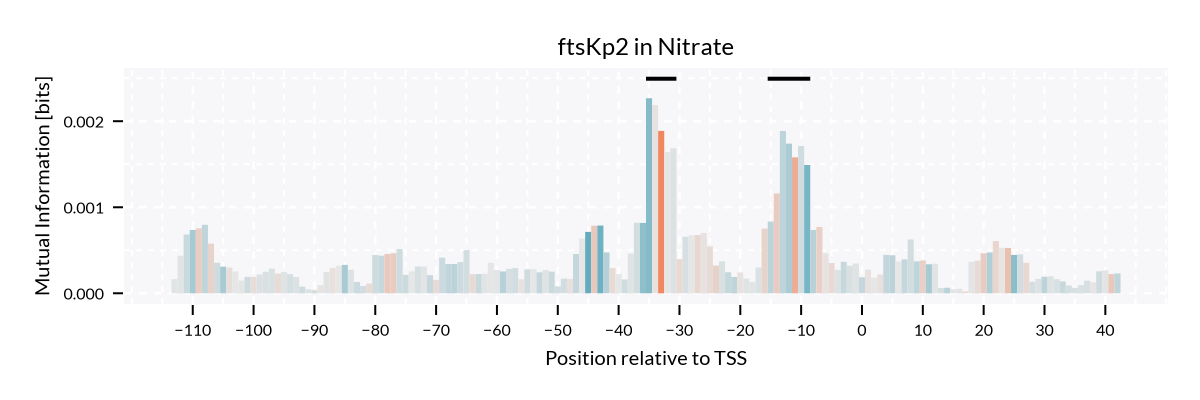

In [159]:
promoter = "ftsKp2"
gc = 40
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

## rspA

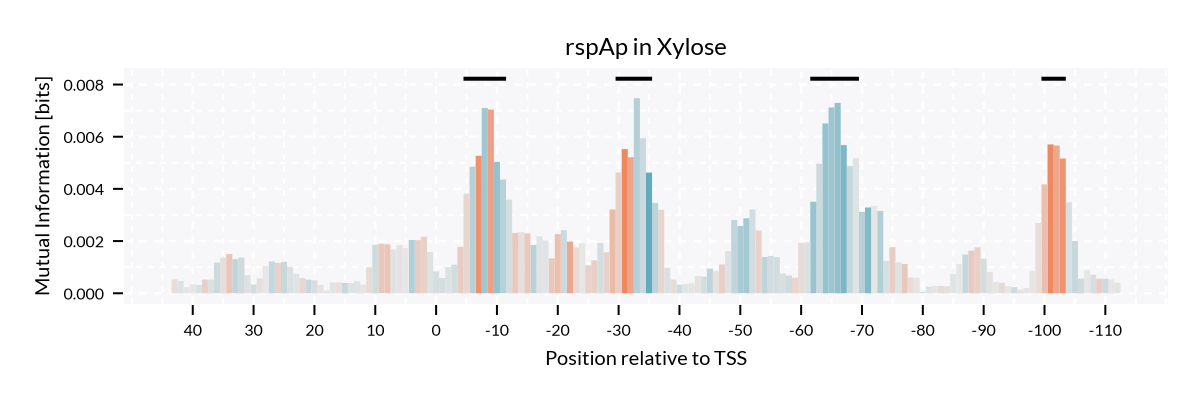

In [114]:
promoter = "rspAp"
gc = 2
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

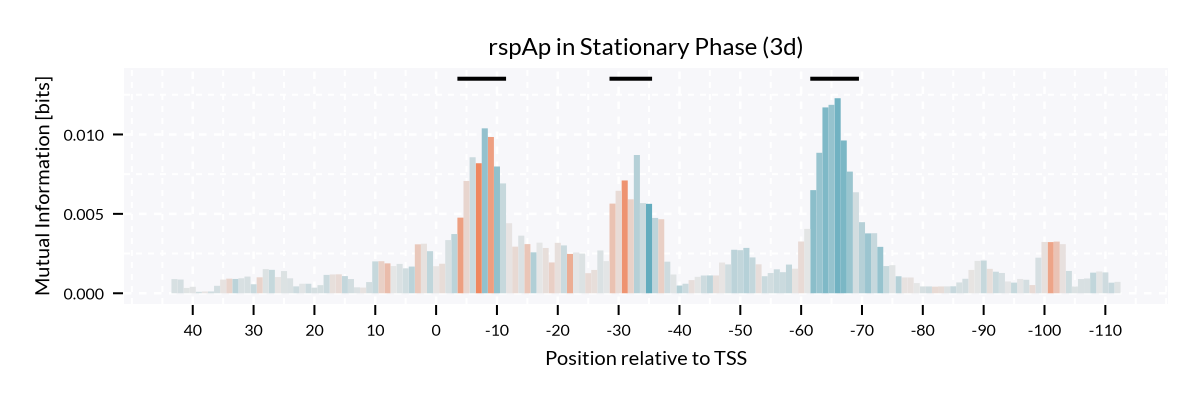

In [106]:
promoter = "rspAp"
gc = 8
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

## xylA

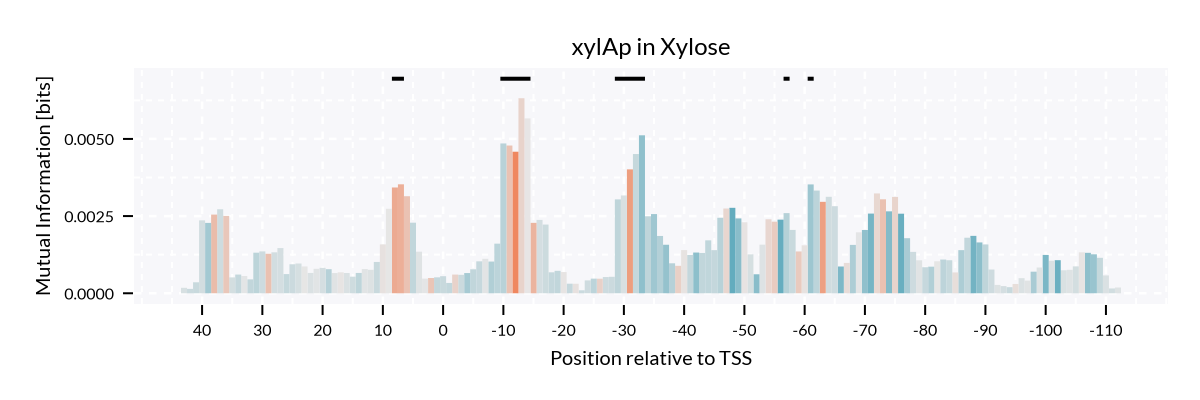

In [160]:
promoter = "xylAp"
gc = 2
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

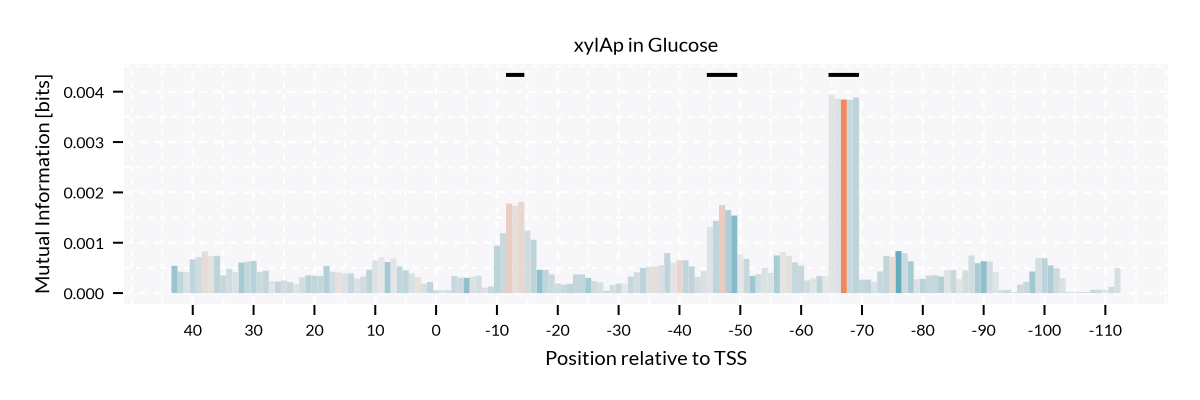

In [26]:
promoter = "xylAp"
gc = 1
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

## xylF

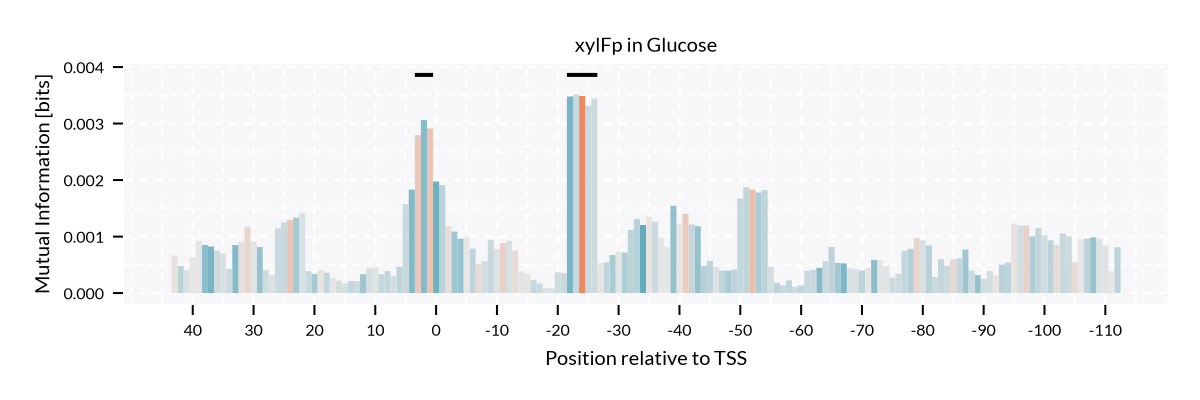

In [27]:
promoter = "xylFp"
gc = 1
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

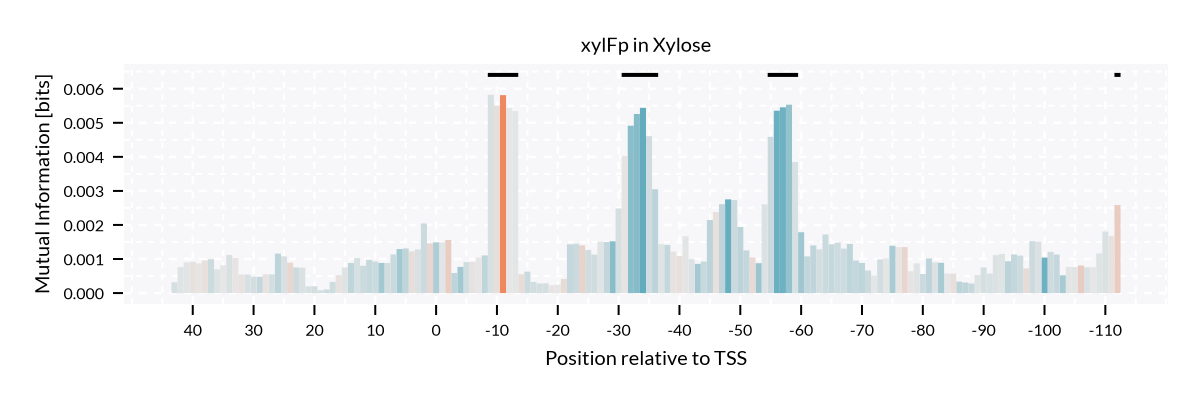

In [28]:
promoter = "xylFp"
gc = 2
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

## dicC

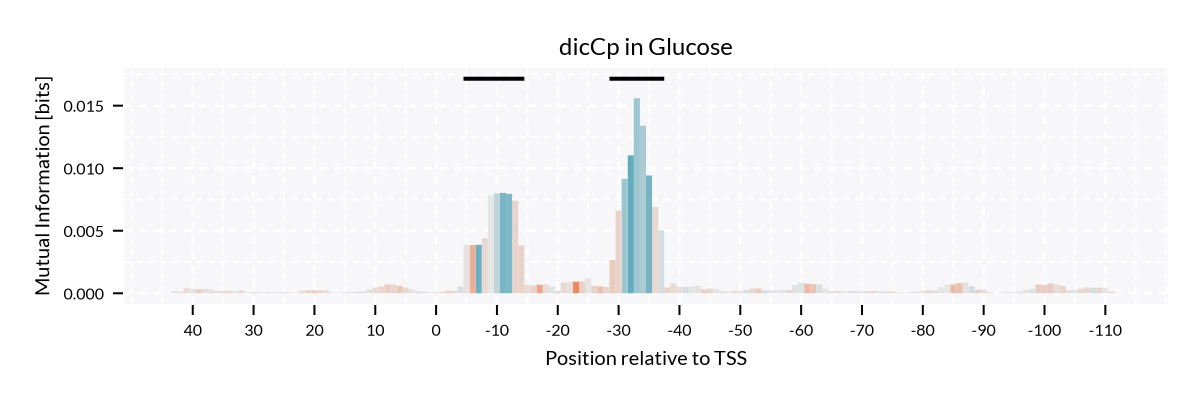

In [98]:
promoter = "dicCp"
gc = 1
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

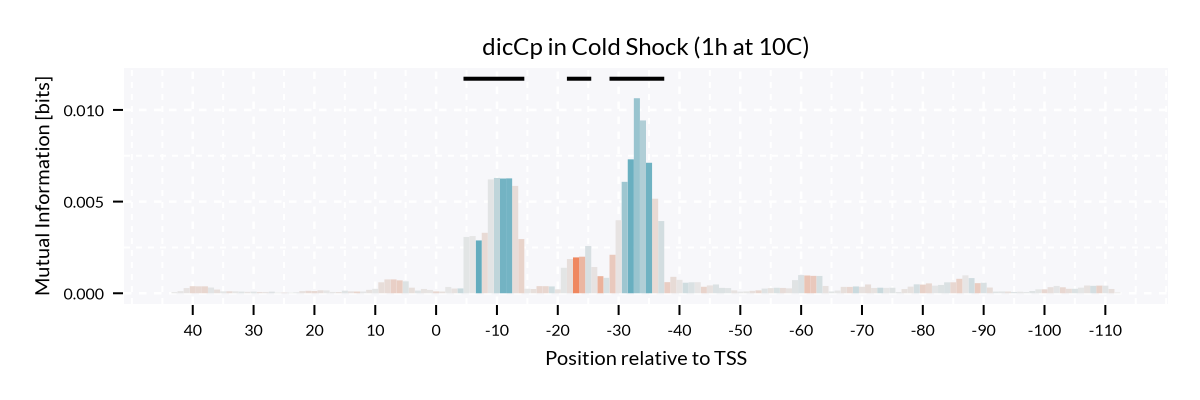

In [99]:
promoter = "dicCp"
gc = 9
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

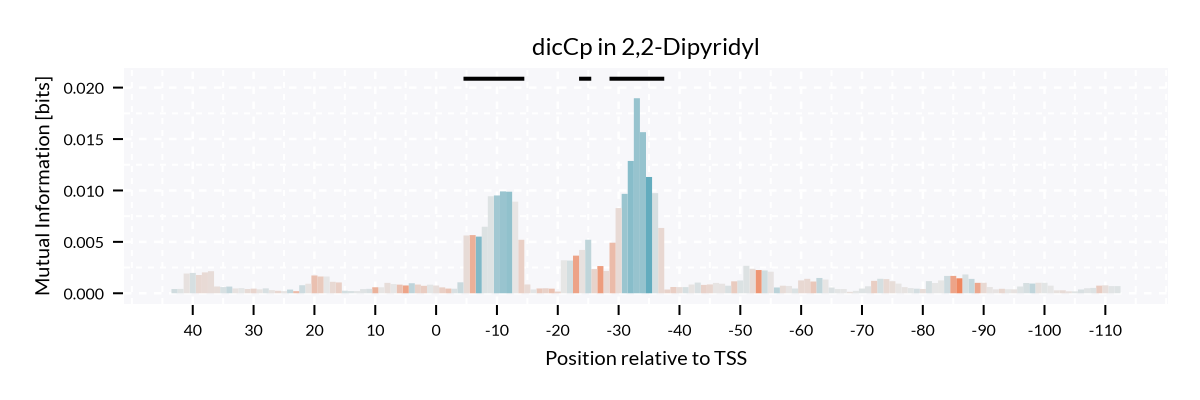

In [101]:
promoter = "dicCp"
gc = 24
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

## relBE

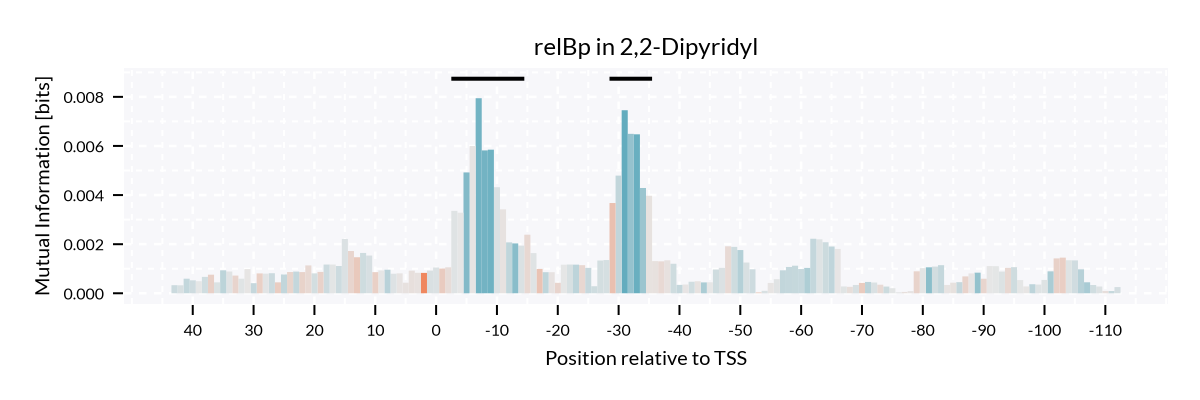

In [134]:
promoter = "relBp"
gc = 24
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

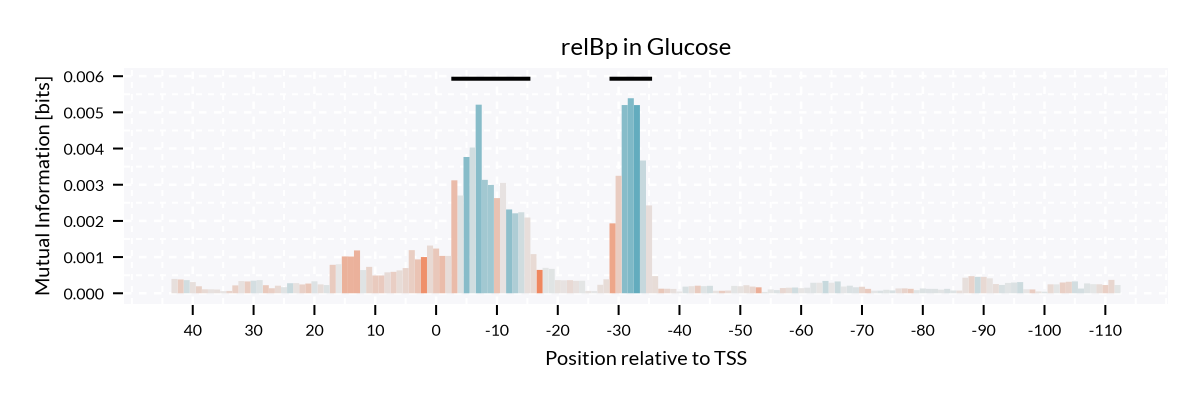

In [137]:
promoter = "relBp"
gc = 1
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

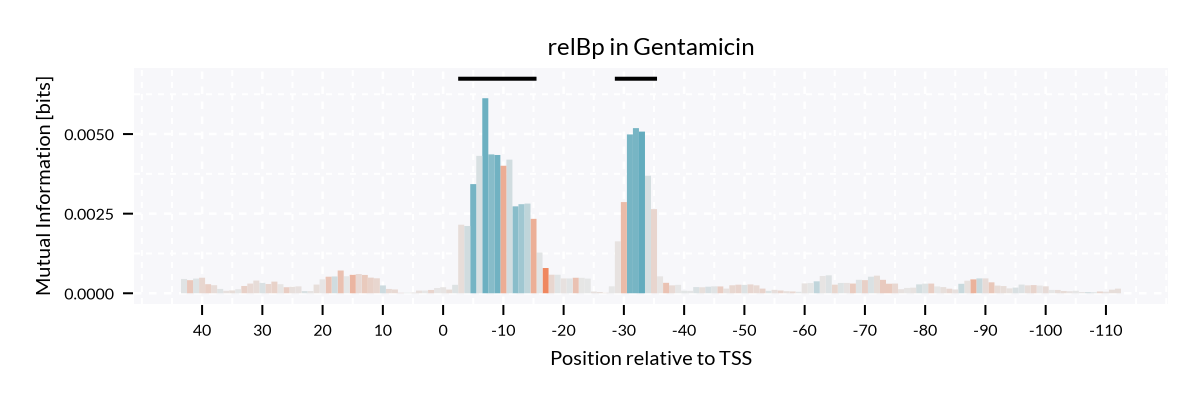

In [161]:
promoter = "relBp"
gc = 29
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

## marR

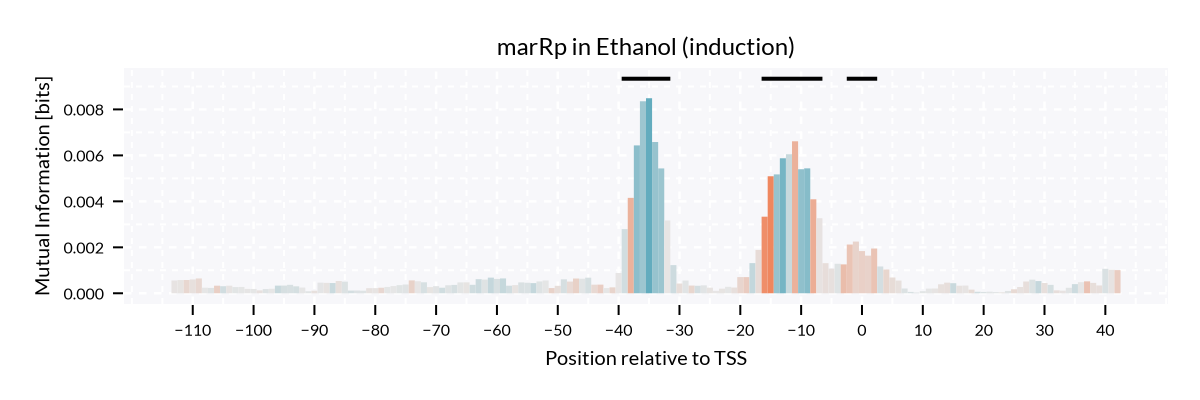

In [129]:
promoter = "marRp"
gc = 19
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

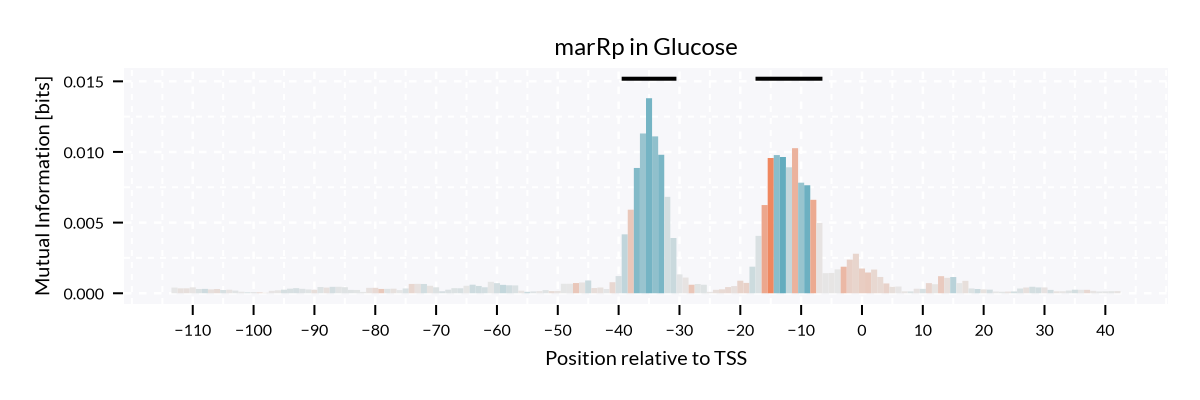

In [130]:
promoter = "marRp"
gc = 1
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

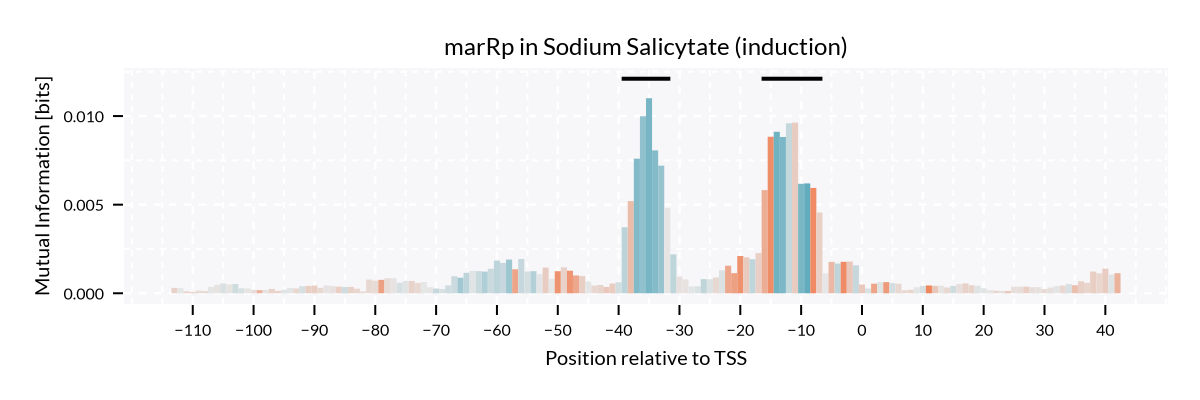

In [162]:
promoter = "marRp"
gc = 17
rep = 1
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

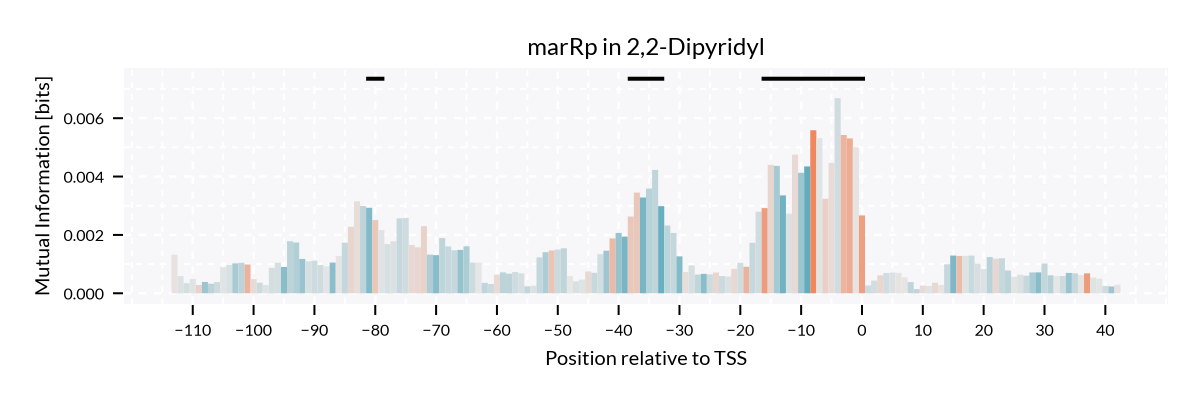

In [163]:
promoter = "marRp"
gc = 24
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

## dgoR

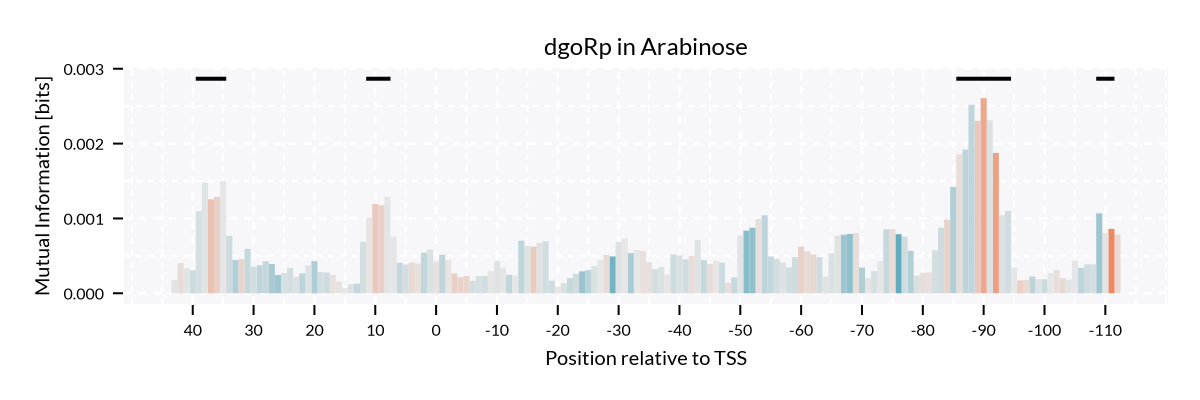

In [102]:
promoter = "dgoRp"
gc = 3
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

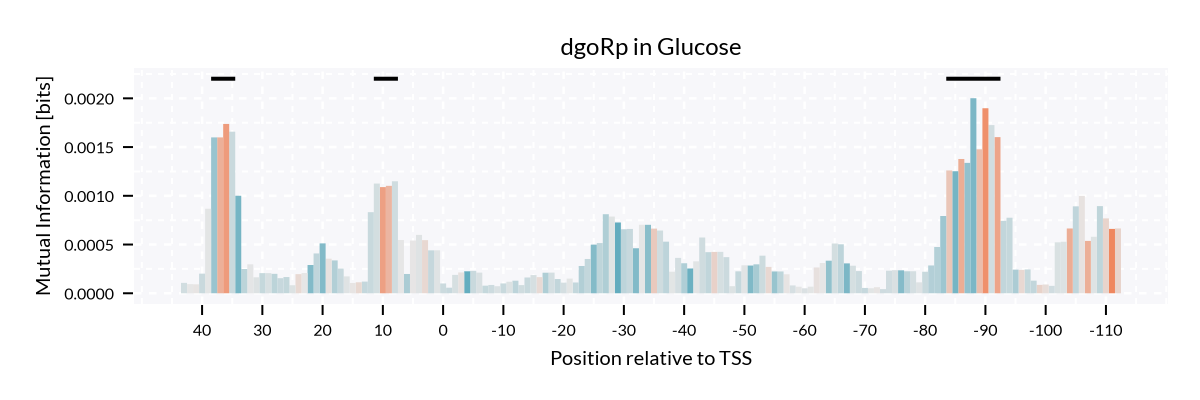

In [103]:
promoter = "dgoRp"
gc = 1
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

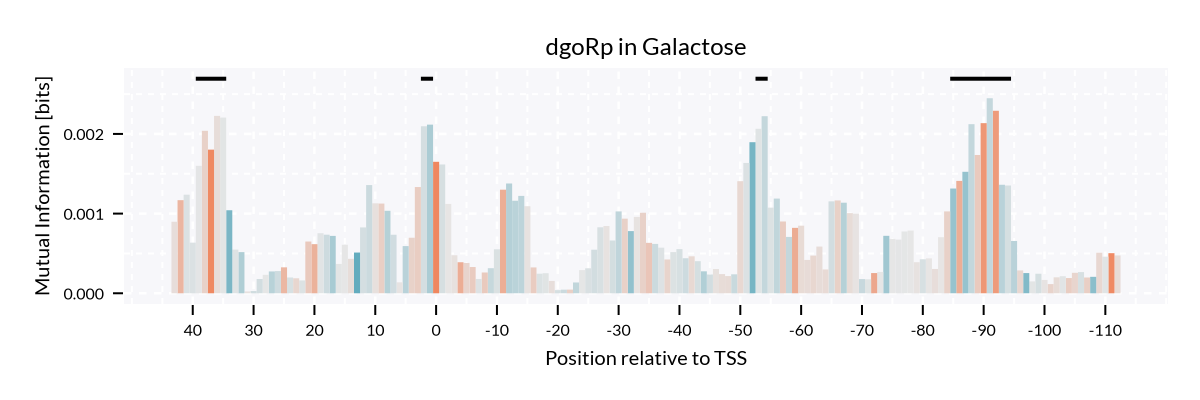

In [104]:
promoter = "dgoRp"
gc = 4
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

## araC

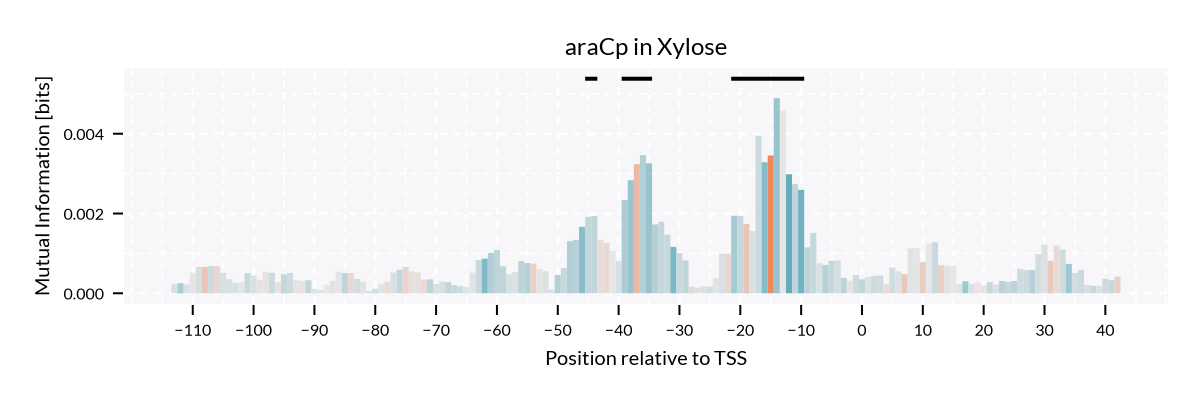

In [90]:
promoter = "araCp"
gc = 2
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

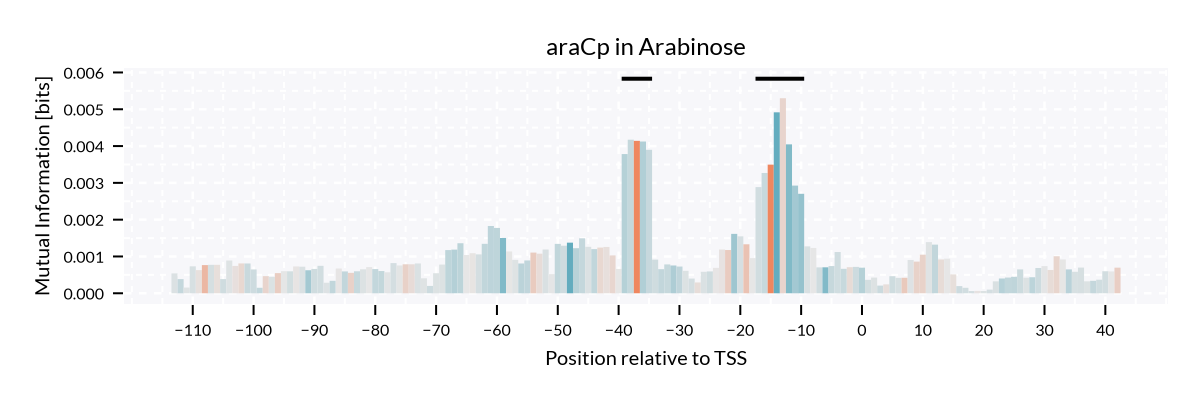

In [91]:
promoter = "araCp"
gc = 3
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

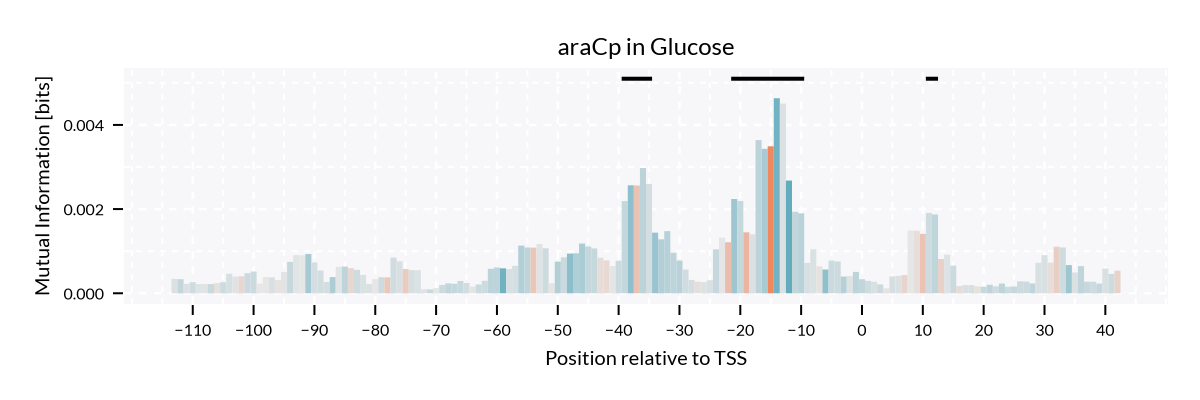

In [92]:
promoter = "araCp"
gc = 1
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

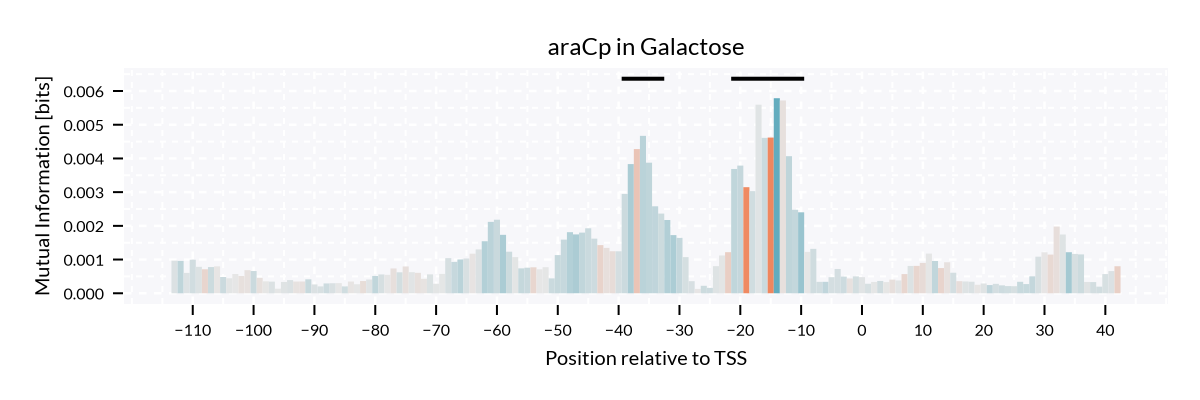

In [93]:
promoter = "araCp"
gc = 4
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

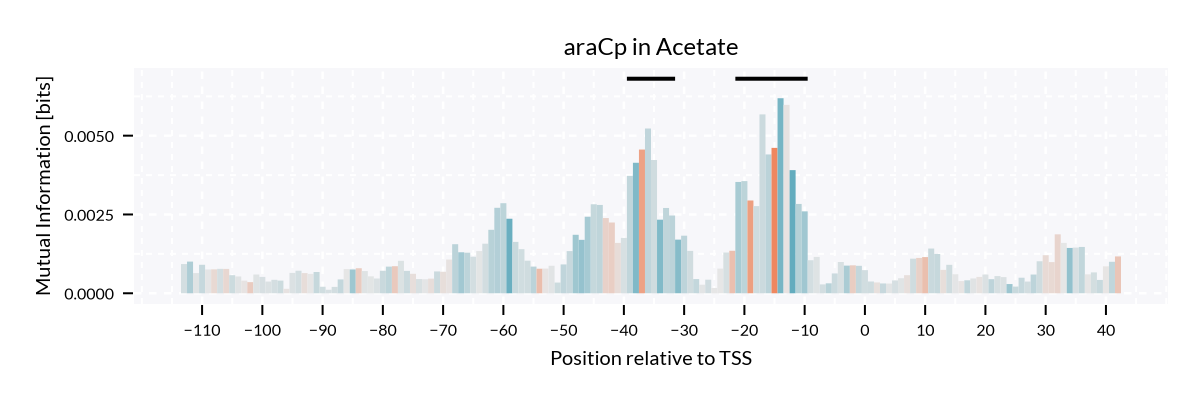

In [164]:
promoter = "araCp"
gc = 39
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

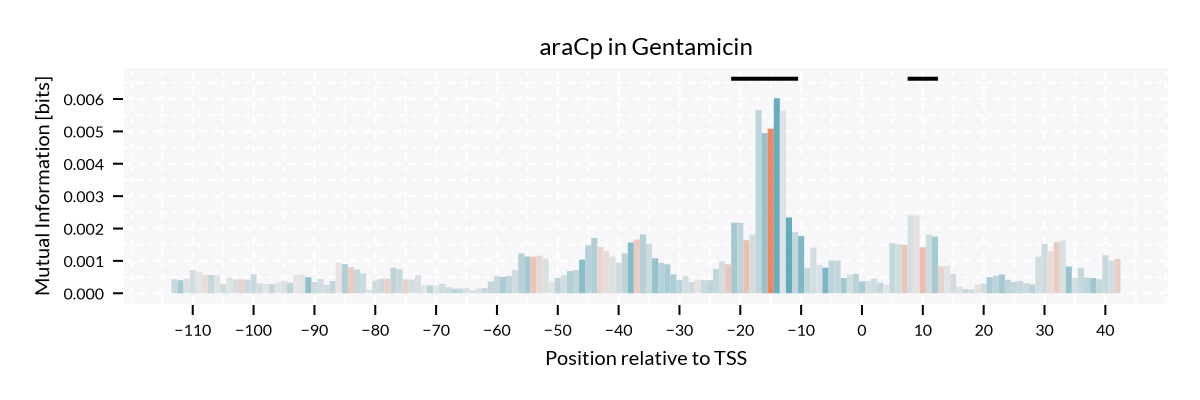

In [165]:
promoter = "araCp"
gc = 29
rep = 2
_, fig = plot_footprint_colored(promoter, gc, rep)
fig

# Toxin/Anti Toxin

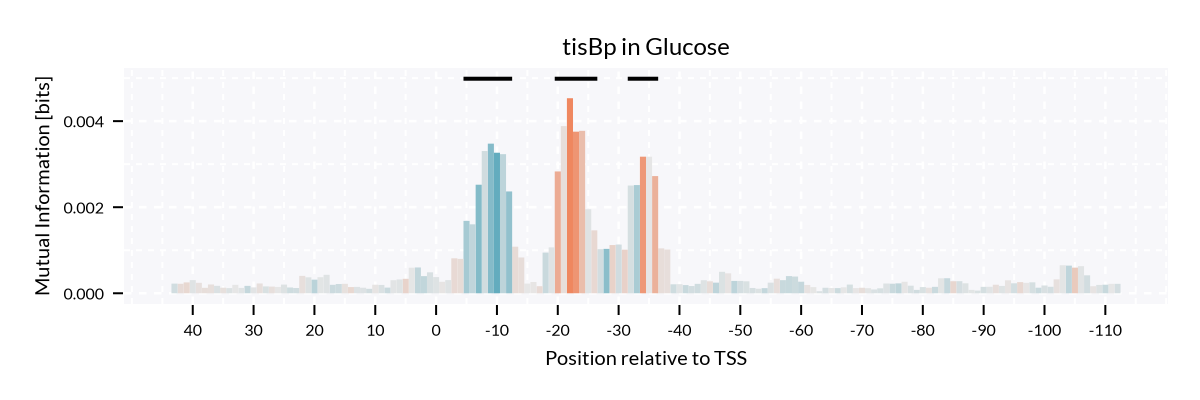

In [96]:
promoter = "tisBp"
gc = 1
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

# Y-ome

## yadI

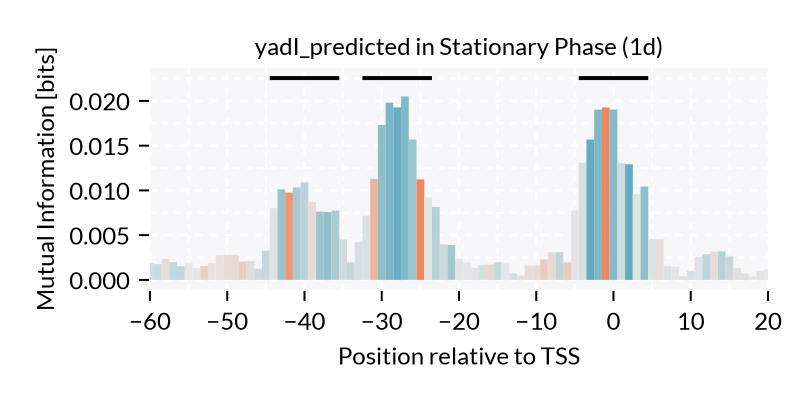

In [69]:
promoter = "yadI_predicted"
gc = 7
rep = 2
ax, fig = plot_footprint_colored(promoter, gc, rep; save_fig=false)
ax.xticklabelsize = 12
ax.yticklabelsize = 12
ax.xlabelsize = 12
ax.ylabelsize = 12
ax.titlesize = 12
xlims!(-60, 20)
resize!(fig.scene, (400, 200))
save("./annotated_footprints/yadI_short.pdf", fig)
fig

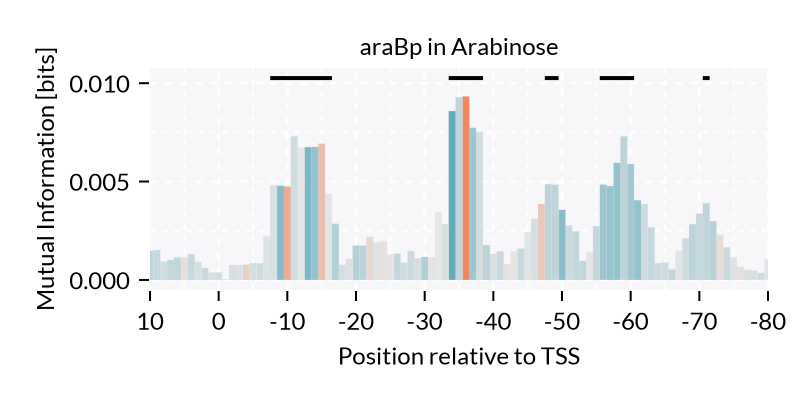

In [70]:
promoter = "araBp"
gc = 3
rep = 2
ax, fig = plot_footprint_colored(promoter, gc, rep, true; save_fig=false)
ax.xticklabelsize = 12
ax.yticklabelsize = 12
ax.xlabelsize = 12
ax.ylabelsize = 12
ax.titlesize = 12
xlims!(-80, 10)
resize!(fig.scene, (400, 200))
save("./annotated_footprints/araBp_short.pdf", fig)
fig


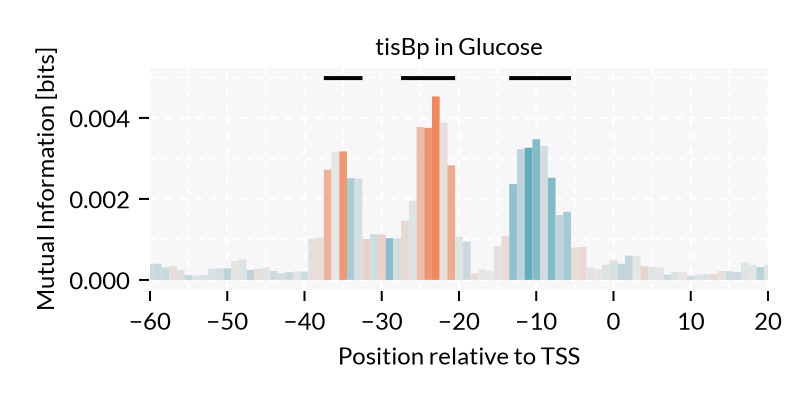

In [71]:
promoter = "tisBp"
gc = 1
rep = 1
ax, fig = plot_footprint_colored(promoter, gc, rep; save_fig=false)
ax.xticklabelsize = 12
ax.yticklabelsize = 12
ax.xlabelsize = 12
ax.ylabelsize = 12
ax.titlesize = 12
xlims!(-60, 20)
resize!(fig.scene, (400, 200))
save("./annotated_footprints/tisBp_short.pdf", fig)
fig

## yacC

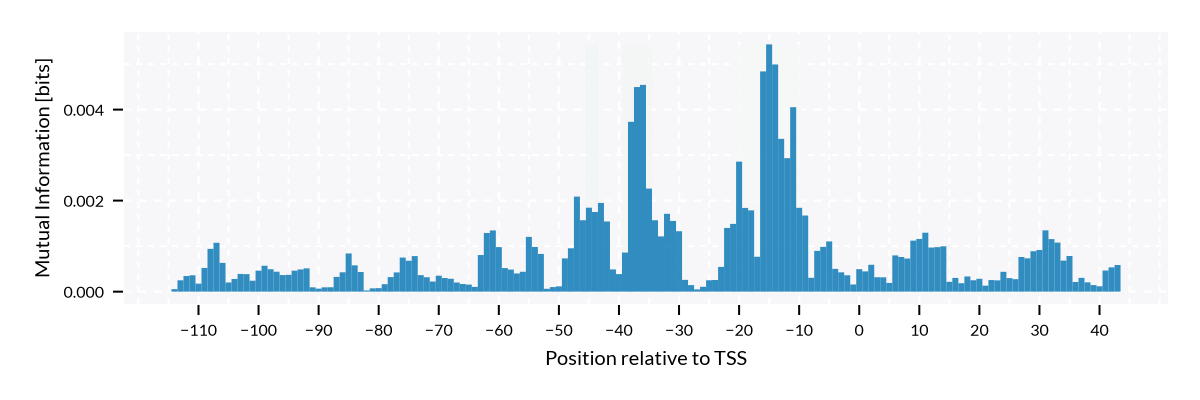

In [118]:
promoter = "araCp"
gc = 2
rep = 2

df = CSV.read("../analysis/all_data/footprints/$gc-$(rep)_footprints.csv", DataFrame)
y = df[(df.promoter .== promoter) .& (df.d .== 1), :mut_info];

df_ex = CSV.read("../analysis/all_data/expression_shifts/$gc-$(rep)_exshifts.csv", DataFrame)
y_ex = df_ex[(df_ex.promoter .== promoter), :];


fig = Figure(size=(600, 200))

ax = Axis(fig[1 ,1], xlabel="Position relative to TSS", ylabel="Mutual Information [bits]", xticks=(collect(-110:10:40)))

_df = df_BS[(df_BS.gc .== gc) .& (df_BS.promoter .== promoter), :]

for bs_df in groupby(_df, :binding_site)
    _x = convert(Vector{Int64}, sort(bs_df.pos)) .- 0.5

    ex_shift = y_ex[map(x -> x ∈ bs_df.pos, y_ex.pos), :]
    color = cmap[(mean(ex_shift.expression_shift) + 1) / 2]
    
    push!(_x, _x[end] + 1)
    band!(
        ax, 
        _x, 
        fill(0, length(bs_df.pos) + 1), 
        fill(maximum(y),length(bs_df.pos) + 1), 
        color=color, 
        )
end

barplot!(ax, -114:43, y, gap=0)

fig

In [119]:
_df = df_BS[df_BS.promoter .== "ybaY_predicted", :]

x = filter(x -> x ∉ [26, 27], collect(1:41))
for prom_df in groupby(df_BS, :promoter)
    fig = Figure(size=(1200, 200 * 39)) 
    
    for i in x
        ax1 = Axis(fig[i, 1], xticks=(-110:10:40), title=get_gc_info(i), xlabel="position relative to TSS", ylabel="mutual info [bits]")
        ax2 = Axis(fig[i, 2], xticks=(-110:10:40), xlabel="position relative to TSS", ylabel="mutual info [bits]")
        ax = [ax1, ax2]
        xlims!(-120, 50)

        
        
        j = 1
        gdf = prom_df[prom_df.gc .== i, :]
        for footprint in footprints
            gc = split(footprint, '-')[1]
            rep = split(split(footprint, '_')[1], '-')[2]
            if gc in collect(keys(skip_conditions))
                if skip_conditions[gc] == rep
                    continue
                end
            end
            df = CSV.read("footprints/$footprint", DataFrame)
            y = df[(df.promoter .== prom_df.promoter[1]) .& (df.d .== 1), :mut_info]
            barplot!(ax[j], -114:43, y, gap=0)
            for bs_df in groupby(gdf, :binding_site)
                _x = convert(Vector{Int64}, sort(bs_df.pos)) .- 0.5
                push!(_x, _x[end] + 1)
                band!(ax[j], _x, fill(0, length(bs_df.pos) + 1), fill(maximum(y),length(bs_df.pos) + 1), color=("gray", 0.3))
                #lines!(ax, sort(bs_df.pos), bs_df.gc, linewidth=2, color="gray")
            end
            j += 1
        end
        
    end
    save("hypothesis/$(prom_df.promoter[1])_predicted_sites_w_footprints.pdf", fig)
end

LoadError: UndefVarError: `get_gc_info` not defined

## CpxR

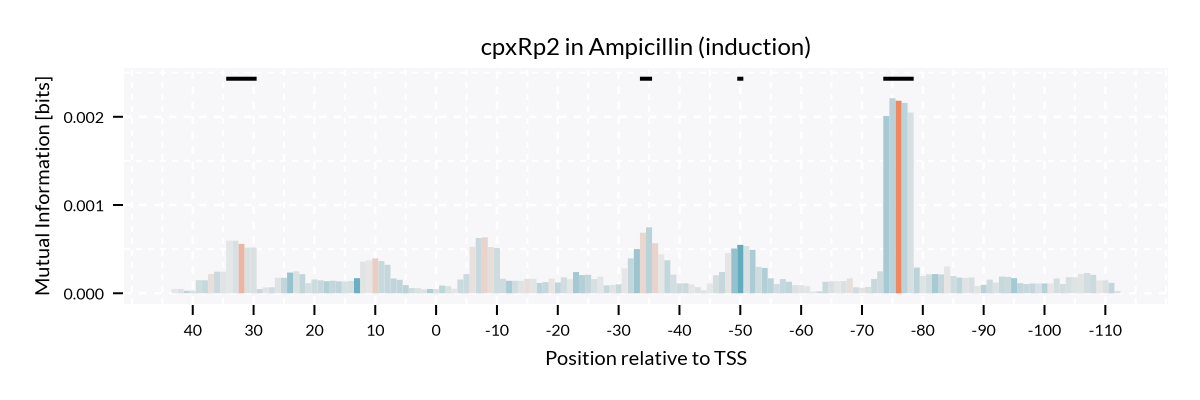

In [166]:
promoter = "cpxRp2"
gc = 18
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

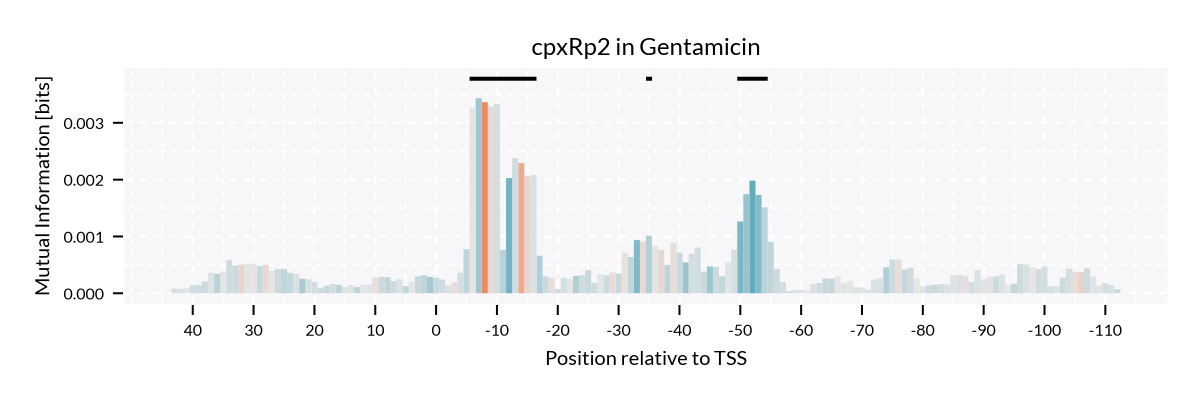

In [167]:
promoter = "cpxRp2"
gc = 29
rep = 1
_, fig = plot_footprint_colored(promoter, gc, rep, true)
fig

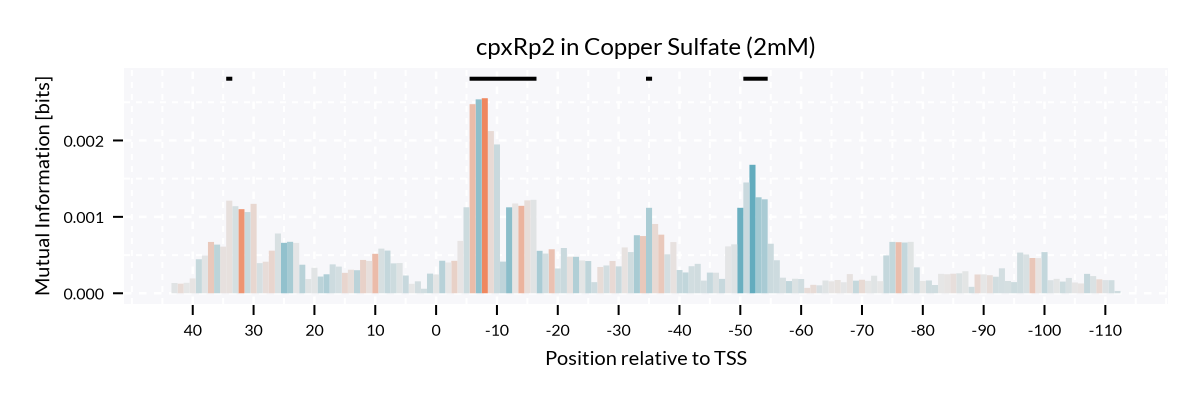

In [168]:
promoter = "cpxRp2"
gc = 38
rep = 3
_, fig = plot_footprint_colored(promoter, gc, rep, true)

fig

## CusC

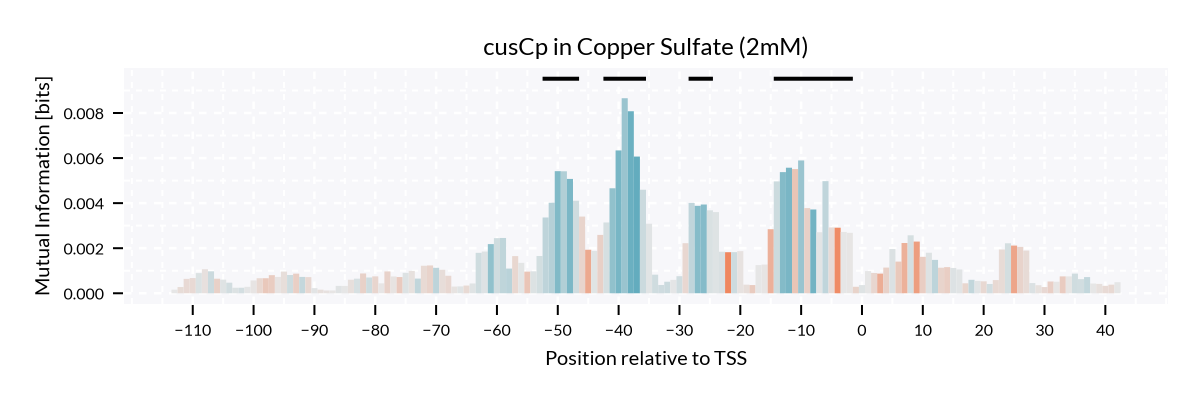

In [169]:
promoter = "cusCp"
gc = 38
rep = 3

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

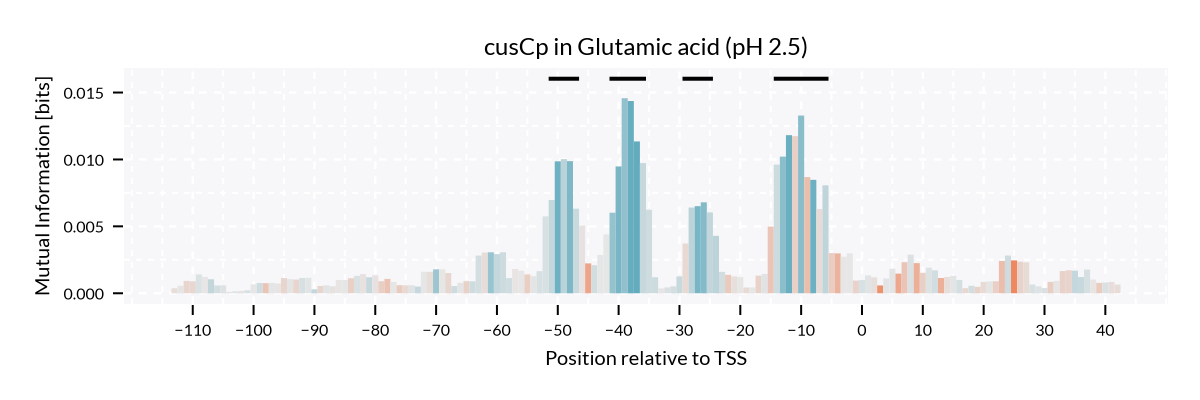

In [178]:
promoter = "cusCp"
gc = 20
rep = 1

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

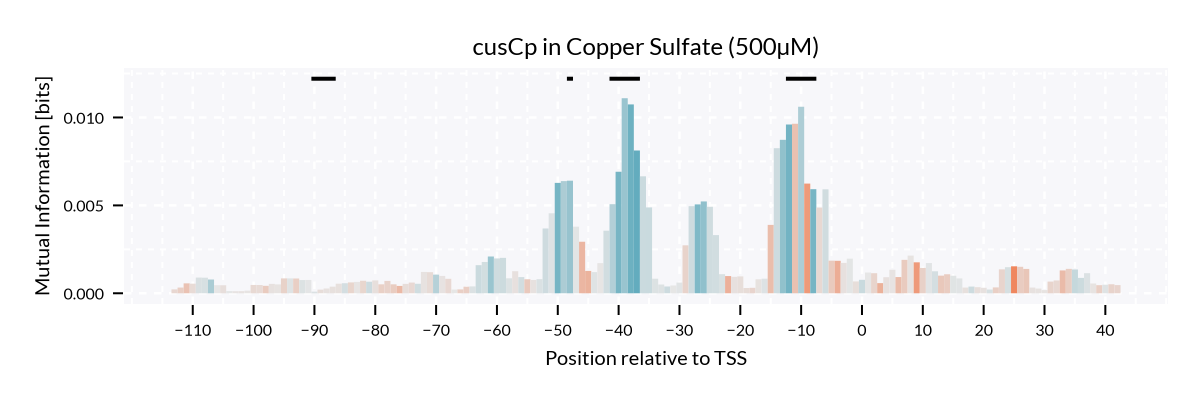

In [176]:
promoter = "cusCp"
gc = 30
rep = 2

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

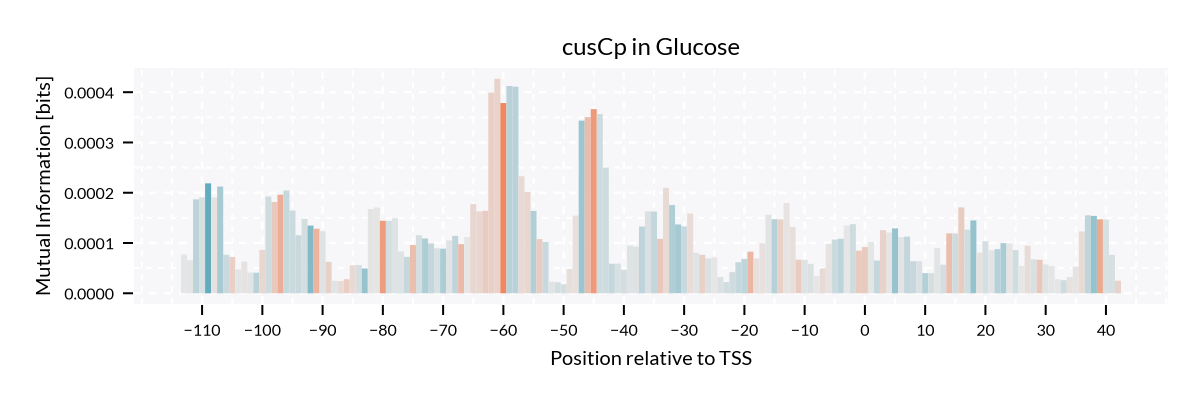

In [171]:
promoter = "cusCp"
gc = 1
rep = 1

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

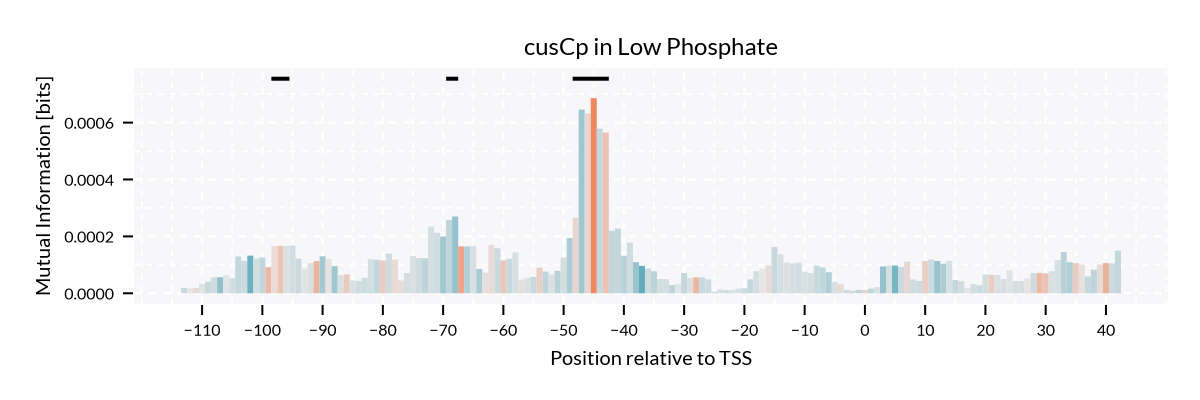

In [181]:
promoter = "cusCp"
gc = 37
rep = 1

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

## CRP

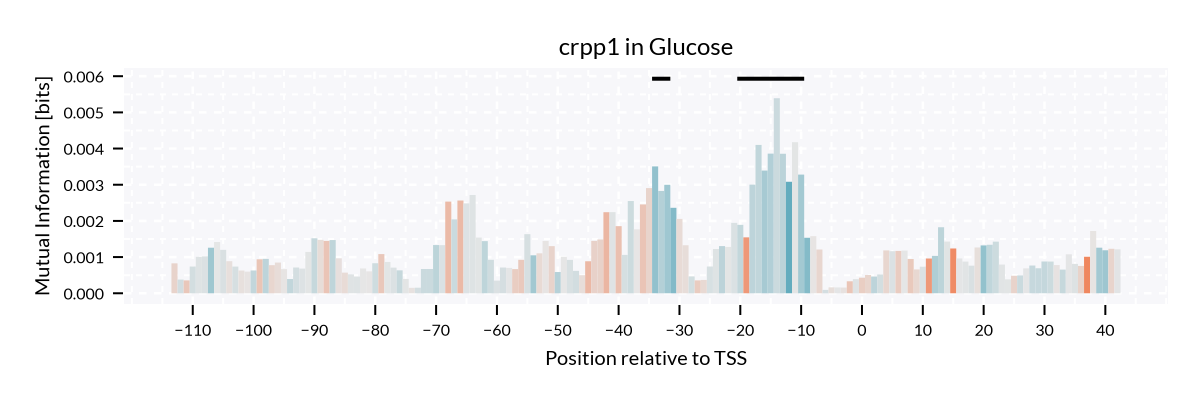

In [154]:
promoter = "crpp1"
gc = 1
rep = 2

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

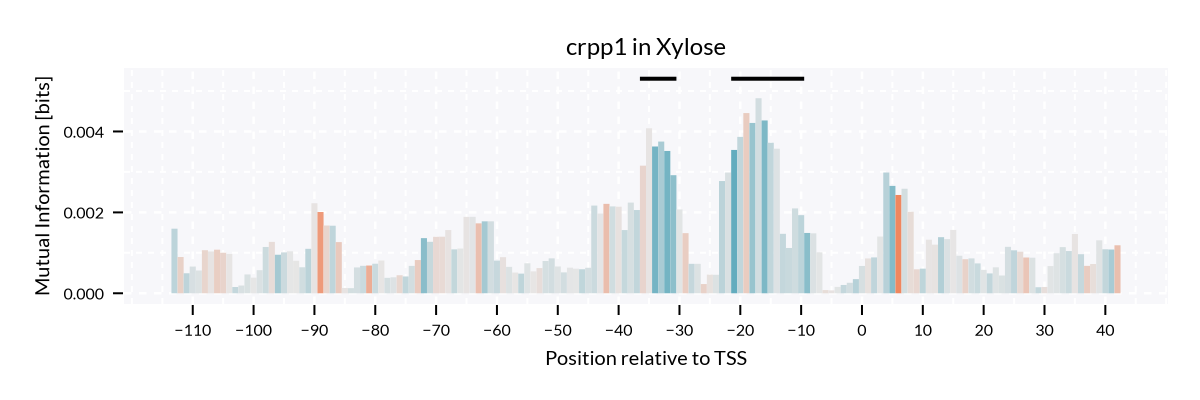

In [81]:
promoter = "crpp1"
gc = 2
rep = 2

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

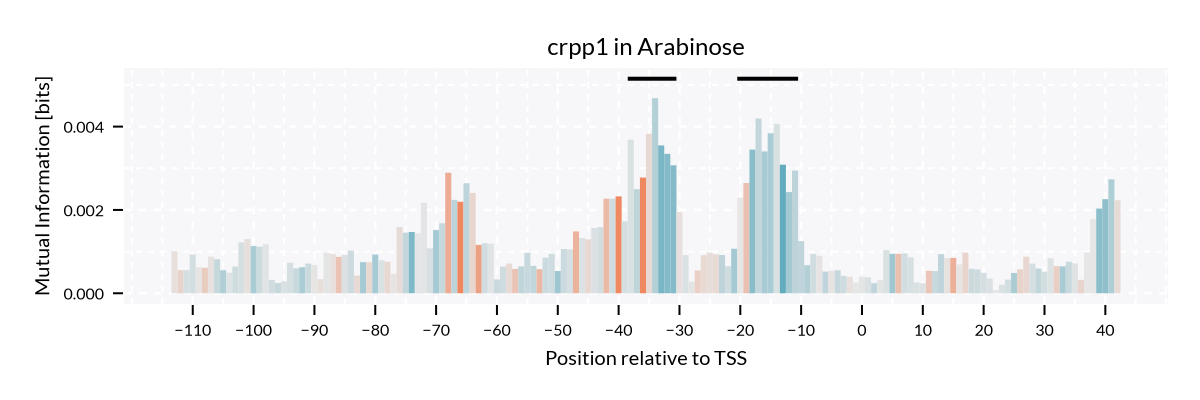

In [82]:
promoter = "crpp1"
gc = 3
rep = 1

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

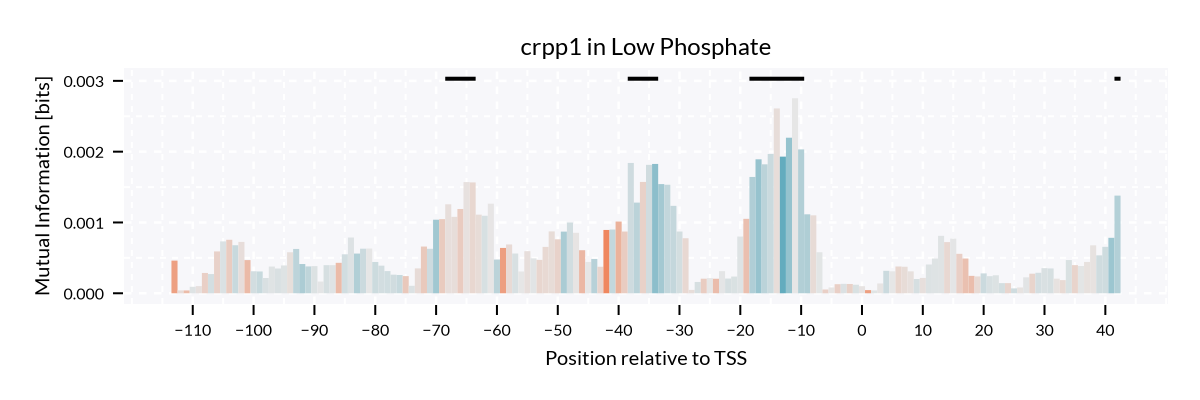

In [172]:
promoter = "crpp1"
gc = 37
rep = 1

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

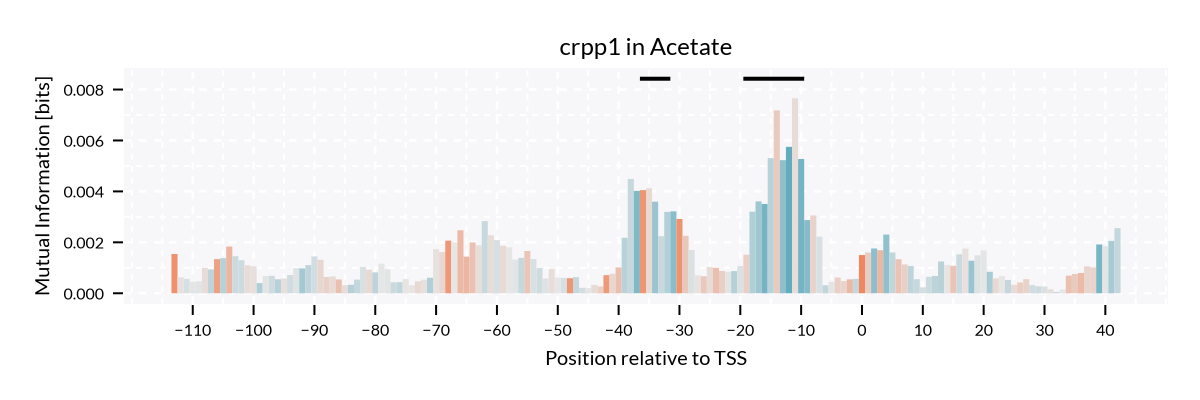

In [173]:
promoter = "crpp1"
gc = 39
rep = 2

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

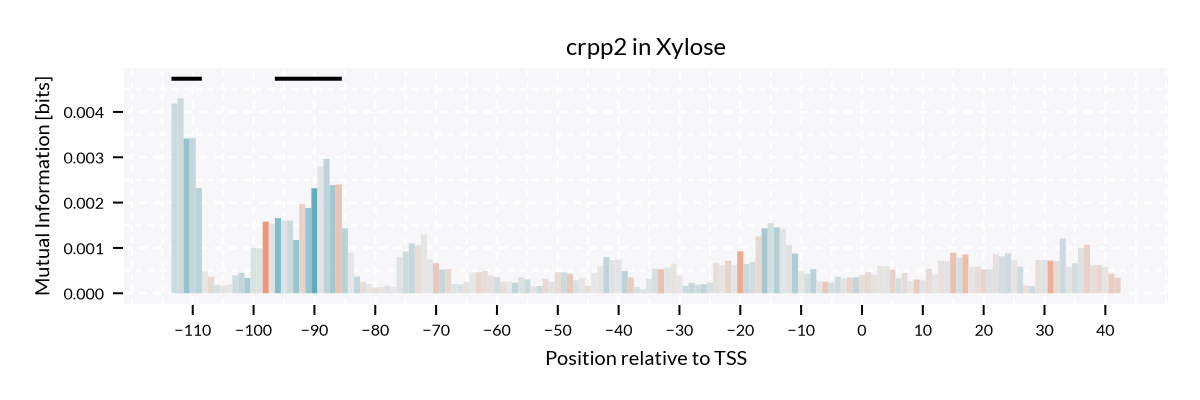

In [85]:
promoter = "crpp2"
gc = 2
rep = 2

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

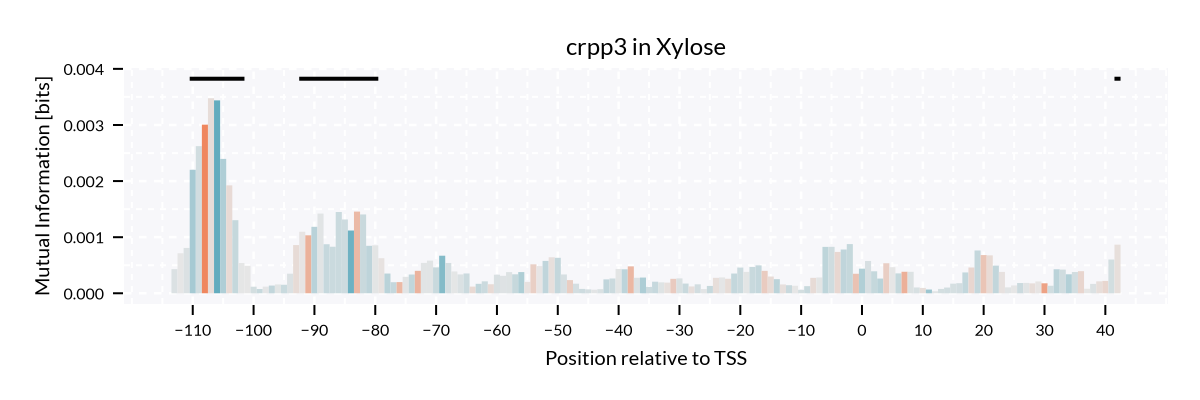

In [86]:
promoter = "crpp3"
gc = 2
rep = 2

_, fig = plot_footprint_colored(promoter, gc, rep)
fig

#### 